Hadas Kharilker

In [ ]:

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,InputLayer
from keras.applications.vgg16 import preprocess_input


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
from matplotlib import cm
from seaborn import heatmap
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow import keras
from sklearn.metrics import confusion_matrix



print(tf.__version__)

2.6.0


**Loading The Eurosat DataSet**

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompletePQLAVU/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


(21600, 64, 64, 3)


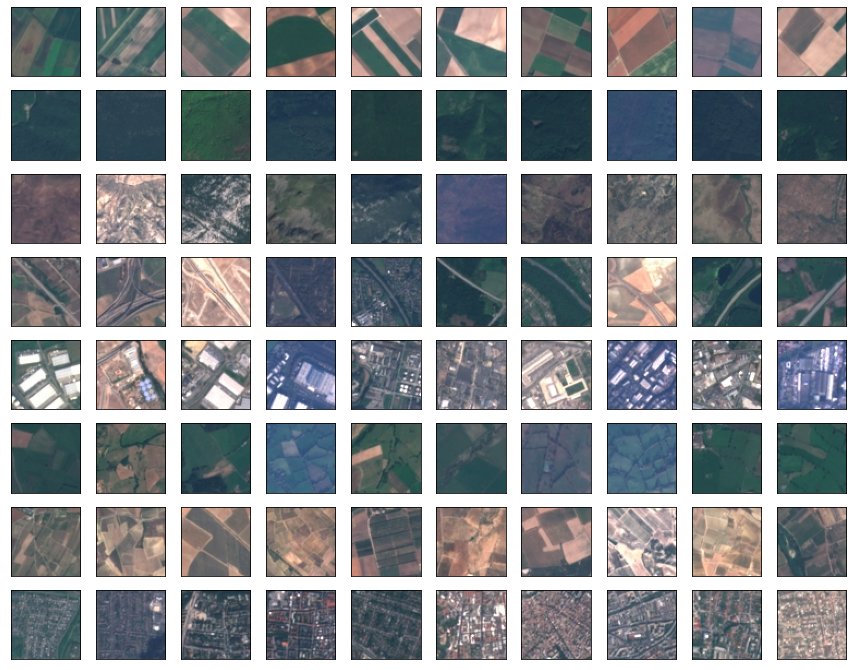

In [ ]:
import tensorflow_datasets as tfds
(train_data, train_labels), (test_data, test_labels) = tfds.as_numpy(tfds.load(
    'eurosat',
    split=['train[:80%]', 'train[80%:]'],
    batch_size = -1,
    shuffle_files = True,
    as_supervised = True))

LABELS = [
'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

train_data = train_data.astype('float32') / 255.0
train_labels = train_labels.flatten()

test_data = test_data.astype('float32') / 255.0
test_labels = test_labels.flatten()
print(train_data.shape)

[idx] = np.where(train_labels==5)
plt.figure(figsize=(15,12))
for c in range(8):
    [idx] = np.where(train_labels == c)
    for i in range(10):
        plt.subplot(8,10,c*10+i+1)
        plt.imshow(train_data[idx[i]])
        plt.xticks([]), plt.yticks([])




**Helper Function** for plotting the results graphs of the models later on

In [ ]:
def plot_results(h, xline=None):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h['loss'],'r', label='train')
    plt.plot(h['val_loss'],':r', label='test')
    if xline is not None:
        plt.axvline(x=xline, linestyle='--', color='k')
    plt.title('Loss',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(h['accuracy'],'b', label='train')
    plt.plot(h['val_accuracy'],':b', label='test')
    if xline is not None:
        plt.axvline(x=xline, linestyle='--', color='k')
    plt.title('Accuracy',fontsize=14)
    plt.xlabel('Epochs',fontsize=14)
    plt.legend()
    plt.grid()

**Part 1 of the project**

Train a ConvNet classifier on the EuroSAT dataset (the RGB version)
*  Stage 1 - designing my own CNN model
*  Stage 2 - use a pretrained network (transfer-learning & fine-tuning). and trying adding data augmention





**Stage 1** - Build and train my own ConvNet model->
 The following m1 model consists from:

*    32 3x3-Conv2D + 2x2 MaxPooling + Dropout(0.2)

*   64 3x3-Conv2D + 2x2 MaxPooling + Dropout(0.2)


*   128 3x3-Conv2D + 2x2 MaxPooling + Dropout(0.2)

*   Faltten + Dense(8)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)      

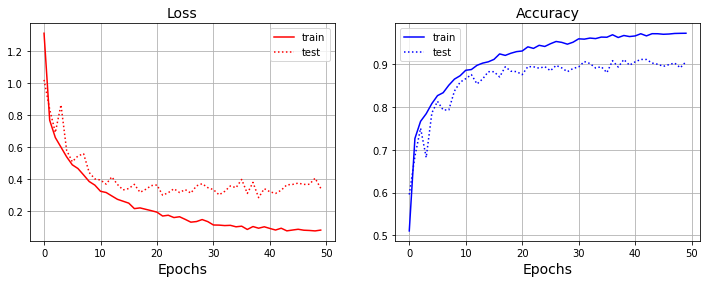

In [ ]:

m1 = Sequential()
m1.add(Conv2D(32, (3,3), activation='relu', padding='same',  input_shape=(64, 64, 3)))
m1.add(MaxPooling2D((2,2)))
m1.add(Dropout(0.2))

m1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
m1.add(MaxPooling2D((2,2)))
m1.add(Dropout(0.2))

m1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
m1.add(MaxPooling2D((2,2)))
m1.add(Dropout(0.2))
m1.add(Flatten())
m1.add(Dense(10,activation='softmax'))

m1.summary()

m1.compile(optimizer='adam',
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

h1 = m1.fit(train_data, train_labels, epochs=50, batch_size=64, validation_data=(test_data, test_labels), verbose=0)
plot_results(h1.history)

In [ ]:
print('train accuracy = ',h1.history['accuracy'][-1])
print('test accuracy = ',h1.history['val_accuracy'][-1])
print('\n')

train accuracy =  0.9724537134170532
test accuracy =  0.9059259295463562




**Stage 2** -  use a pretrained network (transfer-learning & fine-tuning). and trying adding data augmention


In [ ]:
vgg16 = tf.keras.applications.VGG16(input_shape=(64, 64, 3),
                                               include_top=False,
                                               weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


Use pretrained VGG 16+transfer learning - m2 model




In [ ]:
m2 = Sequential()
m2.add(vgg16)
m2.add(Flatten())
m2.add(Dense(10, activation='softmax'))

m2.layers[0].trainable = False # freeze the VGG layers

m2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20490     
Total params: 14,735,178
Trainable params: 20,490
Non-trainable params: 14,714,688
_________________________________________________________________


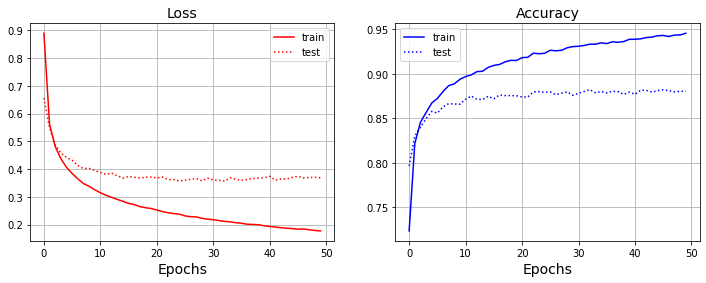

In [ ]:
m2.compile(optimizer='adam',
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

h2 = m2.fit(train_data, train_labels, epochs=50, batch_size=64,
                   validation_data=(test_data, test_labels), verbose=0)
plot_results(h2.history)

In [ ]:
print('train accuracy = ',h2.history['accuracy'][-1])
print('test accuracy = ',h2.history['val_accuracy'][-1])
print('\n')

train accuracy =  0.9456018805503845
test accuracy =  0.8805555701255798




Use pretrained VGG16 + Data augmentation + Transfer learning + Fine tuning - m3 model

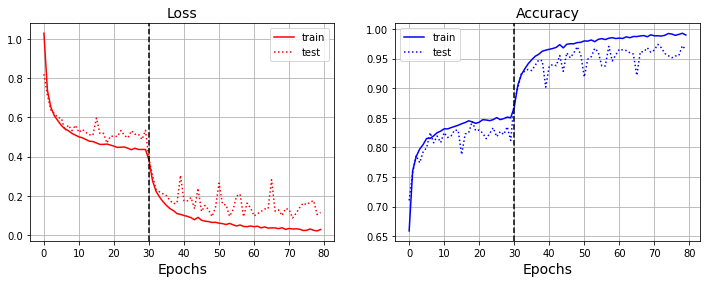

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

augment = Sequential(name = 'augment')
augment.add(preprocessing.RandomFlip())
augment.add(preprocessing.RandomRotation(0.1))
augment.add(preprocessing.RandomTranslation(0.1, 0.1))
augment.add(preprocessing.RandomZoom(0.05))

# combined model:
m3 = Sequential()
m3.add(augment)
m3.add(vgg16)
m3.add(Flatten())
m3.add(Dense(10, activation='softmax'))


# transfer learning
m3.layers[1].trainable = False #  freeze the VGG layers
m3.compile(optimizer='adam',
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

h4 = m3.fit(train_data, train_labels, epochs=30, batch_size=64,
                   validation_data=(test_data, test_labels), verbose=0)

# fine tuning
m3.layers[1].trainable = True #  unfreeze the VGG layers
m3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

h5 = m3.fit(train_data, train_labels, epochs=50, batch_size=64,
                   validation_data=(test_data, test_labels), verbose=0)




# combine h4+h5 results
hh = dict()
for k in h4.history.keys():
    hh[k] = h4.history[k] + h5.history[k]

plot_results(hh, xline=30)

In [ ]:
print('train accuracy = ',h5.history['accuracy'][-1])
print('test accuracy = ',h5.history['val_accuracy'][-1])
print('\n')


train accuracy =  0.9895833134651184
test accuracy =  0.9646296501159668




**Comparison Table**

<table>
  <tr>
    <th>Model</th>
    <th>Epochs</th>
    <th>Train accuracy</th>
    <th>Test accuracy</th>
    <th> Notes </th>
  </tr>
    
  <tr>
    <td> CNN - m1 Model </td>   <!-- Model -->
    <td>50</td> <!-- epochs -->
    <td> 97.24% </td> <!-- train accuracy -->
    <td> 90.59%</td> <!-- test accuracy -->
    <td> Overfitted </td>   <!-- Notes -->
  </tr>



    
   <tr>
    <td> VGG 16+transfer learning - m2 Model </td>   <!-- Model -->
    <td>50</td> <!-- epochs -->
    <td>94.56%</td> <!-- train accuracy -->
    <td> 88.05% </td> <!-- test accuracy -->
    <td>  </td>   <!-- Notes -->
  </tr>


  <tr>
    <td> VGG16 + Data augmentation + Transfer learning + Fine tuning -m3 Model</td>   <!-- Model -->
    <td>80</td> <!-- epochs -->
    <td> 98.95%  </td> <!-- train accuracy -->
    <td> 96.46% </td> <!-- test accuracy -->
    <td> Best Results </td>   <!-- Notes -->
  </tr>


</table>













**Conclusions:**

I got good results with the m3 model (pre trained vgg 16 +Data augmentation + Transfer learning + Fine tuning) and decided to continue with m3 model

**Confusion Matrix of Model m3:**


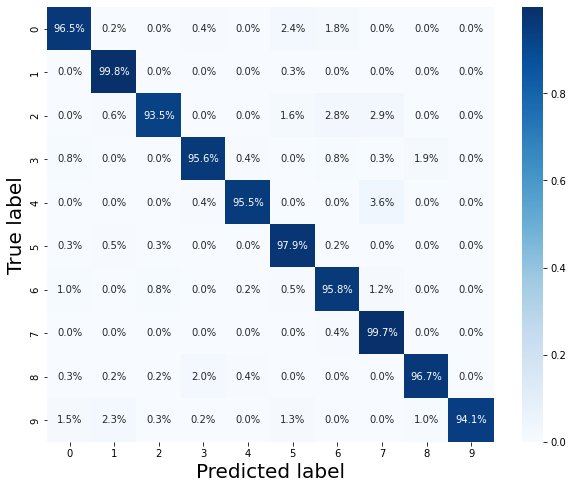

In [ ]:
y_hat = m3.predict(test_data)
y_hat = np.argmax(y_hat, axis=1)
CM = confusion_matrix(test_labels, y_hat)
CM = CM / CM.sum(axis=1)

plt.figure(figsize=(10,8))
heatmap(CM,cmap='Blues',annot=True, fmt='.1%')
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.show()

**Embedding of the feature space in 2-D using TSNA**



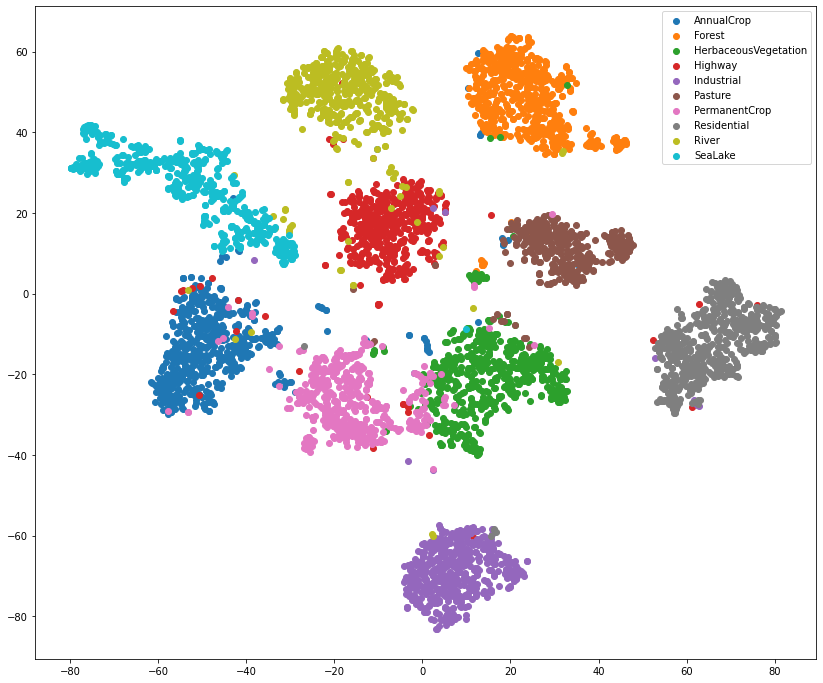

In [ ]:
true_label = np.asarray(test_labels)
features_extractor = keras.Model(inputs=m3.inputs, outputs=m3.layers[-2].output)
features_2D = TSNE(n_components=2).fit_transform(features_extractor.predict(test_data))
plt.figure(figsize=(14,12))
for i in range(10):
    X_label = features_2D[np.where(true_label==i)]
    plt.scatter(X_label[:, 0], X_label[:, 1], label=LABELS[i])
plt.legend()
plt.show()

**Part 2 of the project**

1.   Loading satellite image of Caesarea
2.   Slice it into patches of size 64x64 where stride=8
3. Using m3 model to classify each patch
4. Visualize the classification results
5. Ploting the class probability for any choosen label as a “heatmap”




Defining a function that will slice an large image into patches of size 64x64 where stride=8, predict each patch using m3.predict an build classification canvas and classes probability canvases

In [ ]:
# Gets the original large image and returns the colored canvas and all classes probability canvases
def draw_on_img(large_img):

  # Define the window size
  chopsize = 64 # to make the cropped window 64x64
  width, height = large_img.shape[0], large_img.shape[1]

  canvas = np.zeros([width,height], dtype=np.uint8) # canvas for coloring, same size as original img
  canvas[:] = 7 # color whole canvas in 7 (= background/empty)

  # creating canvases for heatmap of all classes
  heatmap_img1 = np.zeros([width,height], dtype=np.float64)
  heatmap_img2 = np.zeros([width,height], dtype=np.float64)
  heatmap_img3 = np.zeros([width,height], dtype=np.float64)
  heatmap_img4 = np.zeros([width,height], dtype=np.float64)
  heatmap_img5 = np.zeros([width,height], dtype=np.float64)
  heatmap_img6 = np.zeros([width,height], dtype=np.float64)
  heatmap_img7 = np.zeros([width,height], dtype=np.float64)
  heatmap_img8 = np.zeros([width,height], dtype=np.float64)
  heatmap_img9 = np.zeros([width,height], dtype=np.float64)
  heatmap_img10 = np.zeros([width,height], dtype=np.float64)
  jumps = 8 # window moves 8 pixels instead of 64 (87.5% overlapping )

  all_heatmaps = [] # list for of all heatmap images


  for r in range(0,width,jumps):
      for c in range(0,height,jumps):
          window = large_img[r:r+chopsize, c:c+chopsize,:] # gets a window/patch of size 64x64

          if window.shape == (64, 64, 3): # checks windows shape before sending it to model

            window = window.astype('float32') / 255.0 # normalize the window the same way we normalize input, to get predictions
            window = window.reshape(-1, 64,64,3) # reshapes window so it will fit to m3 input

            prediction = m3.predict(window) # send the 64x64 window to model to get a prediction
            prediction_int = np.argmax(prediction, axis=-1) # takes the highest value predicted by the model

            first_prediction = prediction[0][0]  # probability of class 1 predicted by the model
            second_prediction = prediction[0][1] #probability of class 2 predicted by the model
            thired_prediction = prediction[0][2] #probability of class 3 predicted by the model
            Fourth_prediction = prediction[0][3] #probability of class 4 predicted by the model
            Fifth_prediction = prediction[0][4]  #probability of class 5 predicted by the model
            sixth_prediction = prediction[0][5]  #probability of class 6 predicted by the model
            seventh_prediction = prediction[0][6]  #probability of class 7 predicted by the model
            eighth_prediction = prediction[0][7]  #probability of class 8 predicted by the model
            ninth_prediction = prediction[0][8]  #probability of class 9 predicted by the model
            tenth_prediction = prediction[0][9]  #probability of class 9 predicted by the model

            canvas[r:r+chopsize, c:c+chopsize] = prediction_int # colors each window in predicted color. window pixels get the predicted value.

            #color each window in each heatmap  acording to  class prediction value
            heatmap_img1[r:r+chopsize, c:c+chopsize] = first_prediction
            heatmap_img2[r:r+chopsize, c:c+chopsize] = second_prediction
            heatmap_img3[r:r+chopsize, c:c+chopsize] = thired_prediction
            heatmap_img4[r:r+chopsize, c:c+chopsize] = Fourth_prediction
            heatmap_img5[r:r+chopsize, c:c+chopsize] = Fifth_prediction
            heatmap_img6[r:r+chopsize, c:c+chopsize] = sixth_prediction
            heatmap_img7[r:r+chopsize, c:c+chopsize] = seventh_prediction
            heatmap_img8[r:r+chopsize, c:c+chopsize] = eighth_prediction
            heatmap_img9[r:r+chopsize, c:c+chopsize] = ninth_prediction
            heatmap_img10[r:r+chopsize, c:c+chopsize] = tenth_prediction

            all_heatmaps.append(heatmap_img1)
            all_heatmaps.append(heatmap_img2)
            all_heatmaps.append(heatmap_img3)
            all_heatmaps.append(heatmap_img4)
            all_heatmaps.append(heatmap_img5)
            all_heatmaps.append(heatmap_img6)
            all_heatmaps.append(heatmap_img7)
            all_heatmaps.append(heatmap_img8)
            all_heatmaps.append(heatmap_img9)
            all_heatmaps.append(heatmap_img10)





  return canvas,all_heatmaps

In [ ]:
# load the original Cesarea image using tifffile
large_img=tiff.imread('Cesarea.tiff')

#sending the original large image to draw_on_image func,
#the function returns the colored canvas and all classes probability canvases
canv, all_heatmaps = draw_on_img(large_img) # canv = multi-class coloring, cancer_heatmap = tumor probability heatmap


**Ploting classification results**

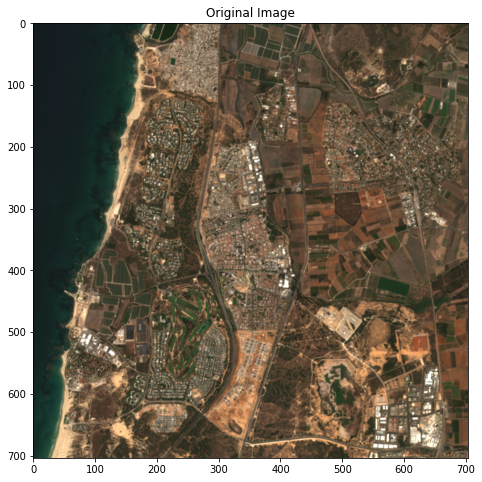

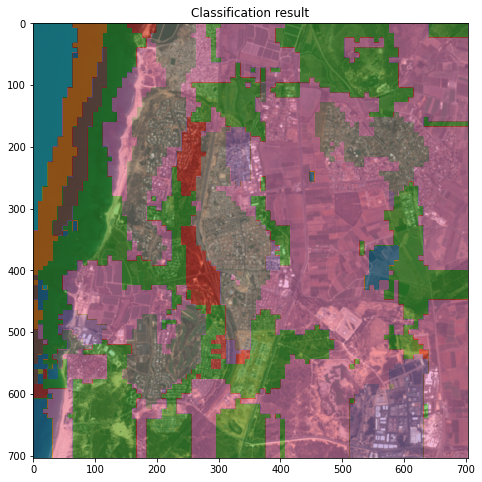

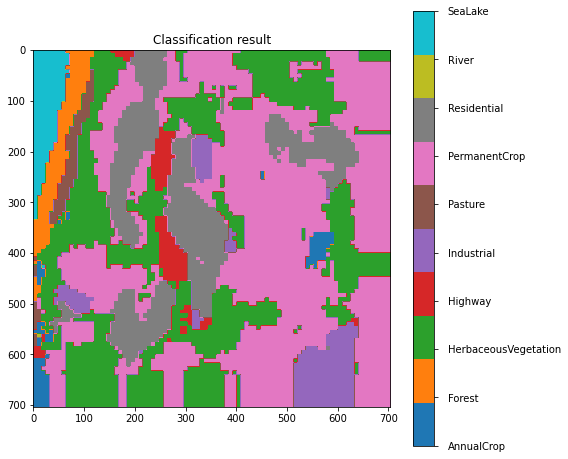

In [ ]:


#plotting  original image
plt.figure(figsize = (8,8))
plt.imshow(large_img)
plt.title("Original Image")

#plotting classifiction result on top od original image

plt.figure(figsize = (8,8))
plt.imshow(canv,cmap='tab10',vmin=0, vmax=9)
plt.imshow(large_img, alpha=0.5)
plt.title("Classification result")

#plotting  image classes
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(canv,cmap='tab10',vmin=0, vmax=9)
cb = plt.colorbar(im)
plt.title("Classification result")

ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(LABELS,ha='left')
cb.ax.yaxis.set_tick_params(pad=10 )





**Ploting all classes probability heatmaps**





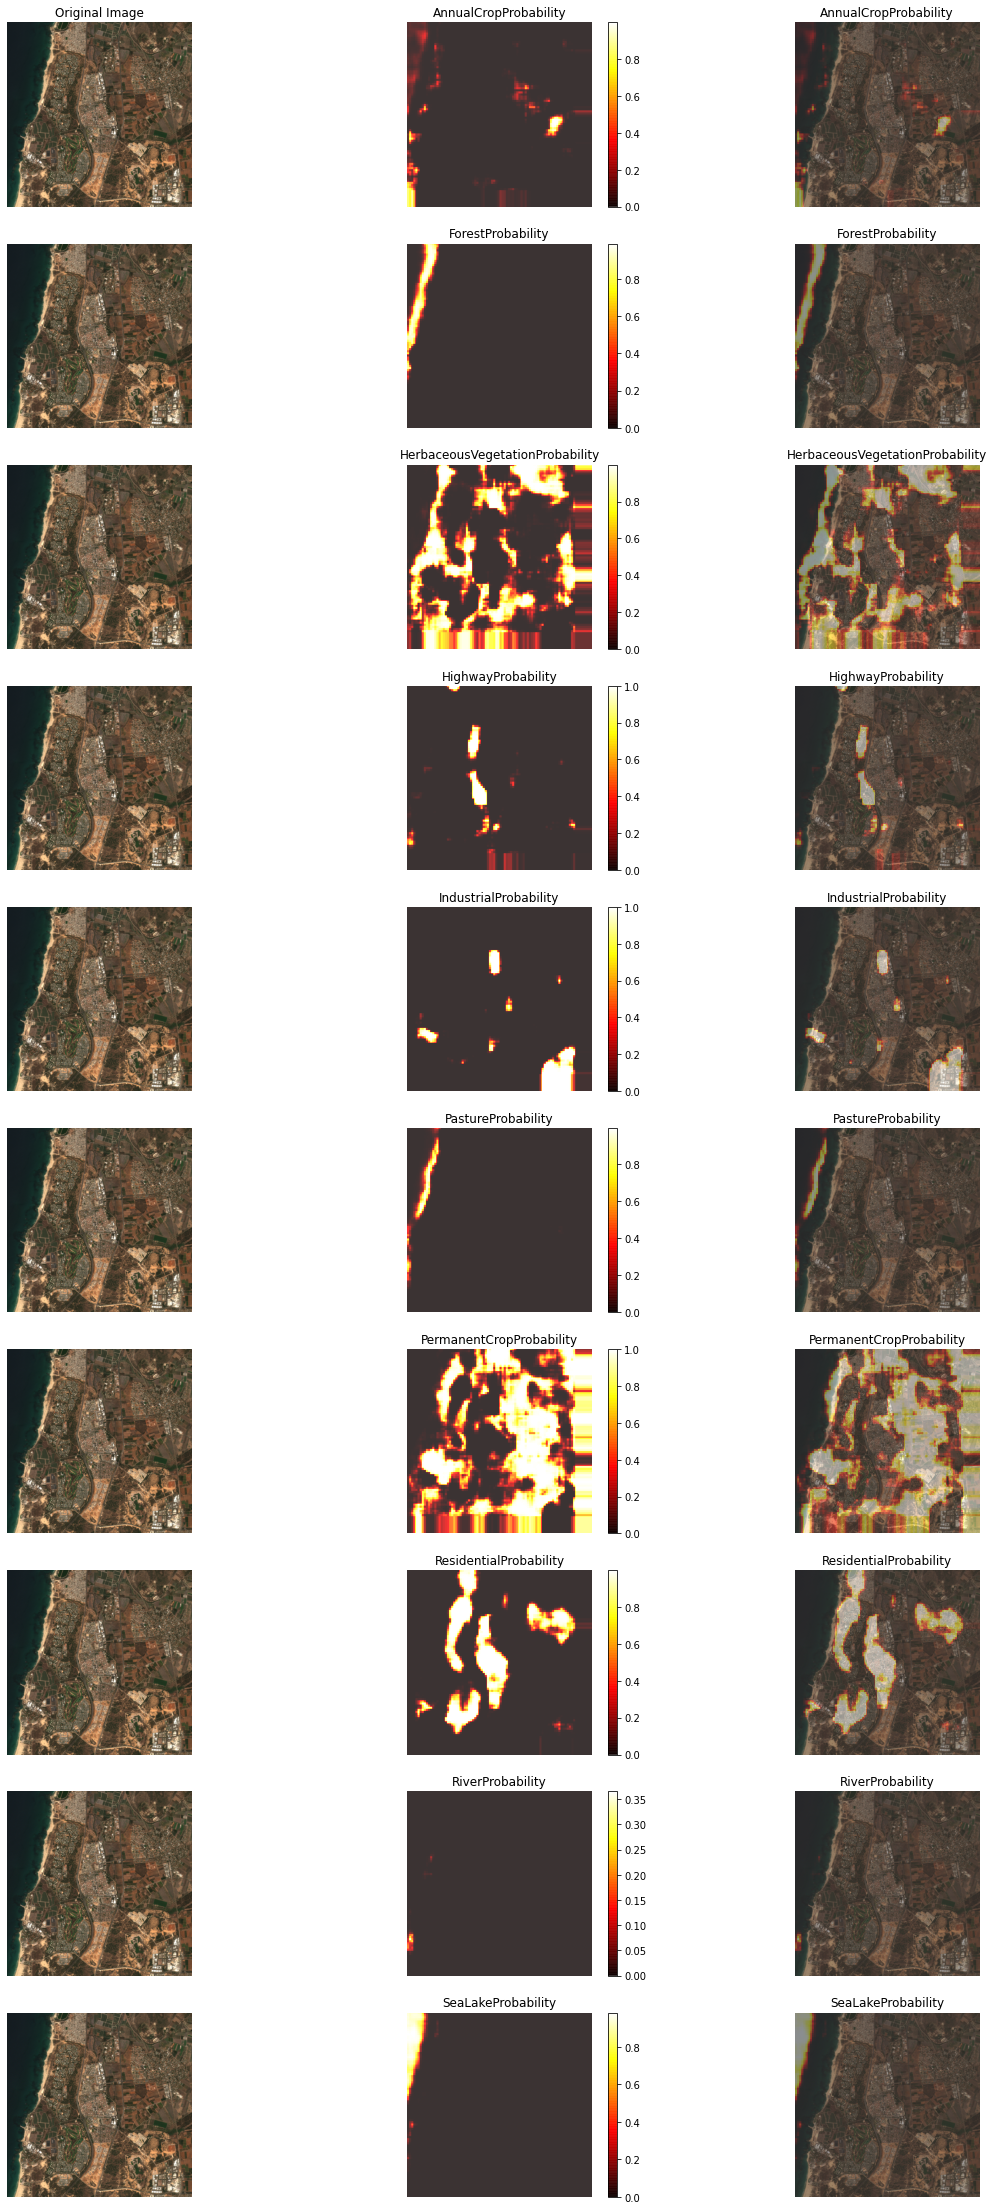

In [ ]:

k = 1 # number in subplot

plt.figure(figsize=(20,40))
for i in range(0,10):
    plt.subplot(10,3,k)
    plt.imshow(large_img)
    plt.axis('off')
    if i == 0: # only first image gets a title
        plt.title("Original Image")
    k += 1



    plt.subplot(10,3,k)
    plt.imshow(all_heatmaps[i], cmap='hot',alpha=0.8)
    plt.colorbar()
    plt.axis('off')
    plt.title( LABELS[i]+'Probability')
    k += 1

    plt.subplot(10,3,k)
    plt.imshow(all_heatmaps[i], cmap='hot',alpha=0.8)
    plt.imshow(large_img,alpha=0.5)
    plt.axis('off')
    plt.title(LABELS[i]+'Probability')
    k += 1
    print('\n')

plt.show()